## This notebook is used to preprocess data and transform into an appropriate format for an LSTM

In [ ]:
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
import pandas
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np

Create a mapping to transform the dataset into columns per sensor

In [ ]:
replacement_mapping_dict = {
            "M01" : 0,
            "M02" : 1,
            "M03" : 2,
            "M04" : 3,
            "M05" : 4,
            "M06" : 5,
            "M07" : 6,
            "M08" : 7,
            "M09" : 8,
            "M10" : 9,
            "M11" : 10,
            "M12" : 11,
            "M13" : 12,
            "M14" : 13,
            "M15" : 14,
            "M16" : 15,
            "M17" : 16,
            "M18" : 17,
            "M19" : 18,
            "M20" : 19,
            "M21" : 20,
            "M22" : 21,
            "M23" : 22,
            "M24" : 23,
            "M25" : 24,
            "M26" : 25,
            "I01" : 26,
            "I02" : 27,
            "I03" : 28,
            "I04" : 29,
            "I05" : 30,
            "I06" : 31,
            "I07" : 32,
            "I08" : 33,
            "D01" : 34,
            "AD1-A" : 35,
            "AD1-B" : 36,
            "AD1-C" : 37,
        }

Load the dataset.

In [ ]:
dataset = read_csv('datasets/adlnormal/data.csv')
# for now exclude asterisk and EO1
dataset = dataset[dataset["SensorId"] != "E01"]
dataset = dataset[dataset["SensorId"] != "asterisk"]

# replace ON/OFF for light sensors, ABSENT/PRESENT for bowls/food and OPEN/CLOSE for door sensors
dataset["SensorValue"] = dataset["SensorValue"].replace({"ON" : 1.0, "OFF" : 0.0})
dataset["SensorValue"] = dataset["SensorValue"].replace({"ABSENT" : 1.0, "PRESENT" : 0.0})
dataset["SensorValue"] = dataset["SensorValue"].replace({"OPEN" : 1.0, "CLOSE" : 0.0})
# transform sensorids from text into numbers to make life easier
dataset["SensorId"].replace(replacement_mapping_dict, inplace=True)
# drop the event labelling as we aren't predicting activities
dataset.drop('Event', axis=1, inplace=True)

Now, create a transformed data set where the columns represent the various sensor values.
Furthermore, collate the data into 10 second segments to reduce sparcity. 
To avoid empty fields, oscillations of on/off values will be simply reported as 1 - representing activation

In [ ]:
data = []
current_date = dataset.iloc[0]["Date"]
first_row_time = dataset.iloc[0]["Time"].split(".")
first_row_time = first_row_time[:1]
current_time = ((datetime.strptime(first_row_time[0], "%H:%M:%S").second // 10 ) + 1 ) * 10 
if (current_time > 50):
    current_time = 60
sensor_vals = [0.0] * 38
first_time = datetime.strptime(first_row_time[0], "%H:%M:%S")
date_and_time = []
date_and_time.append(current_date)
date_and_time.append(str(first_time.hour) + ":" + str(first_time.minute) + "." + str(current_time))
for i, row in dataset.iterrows():
    date = row["Date"]
    time = row["Time"].split(".")
    time = time[:1]
    time = datetime.strptime(time[0], "%H:%M:%S")
    if ((current_time == 60 and time.second < current_time ) or time.second >= current_time):
        date_and_time.extend(sensor_vals)
        data.append(date_and_time)
        date_and_time = []
        current_date = date
        if (current_time == 60):
            current_time = 10
        else:
            current_time += 10
        sensor_vals = [0.0] * 38
        if (sensor_vals[int(row["SensorId"])] != 1.0):
            sensor_vals[int(row["SensorId"])] = row["SensorValue"]
        date_and_time.append(row["Date"])
        new_time = str(time.hour) + ":" + str(time.minute) + "." + str(current_time)
        date_and_time.append(new_time)
    if (sensor_vals[int(row["SensorId"])] != 1.0):
        sensor_vals[int(row["SensorId"])] = row["SensorValue"]
columns = [i for i in range (0,38)]
final_columns = ["Date", "Time"]
final_columns.extend(columns)
new_data = pandas.DataFrame.from_records(data, columns=final_columns)      

Plot the data to identify useless fields

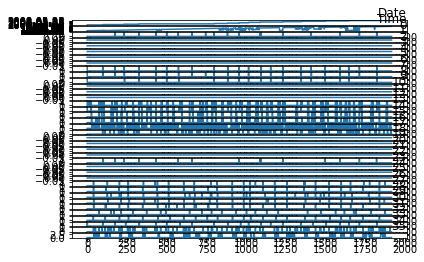

Irrelevant columns are:  [1, 2, 3, 4, 5, 9, 10, 11, 18, 19, 20, 21, 23, 24, 25]


In [17]:
values = new_data.values
groups = []
empty_columns = []
for i in range (0,38):
    groups.append(i)
    if ((new_data[i] == new_data[i][0]).all()):
        empty_columns.append(i)
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(new_data.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()
print("Irrelevant columns are: ", empty_columns)


Remove empty columns from the data and plot resulting traces

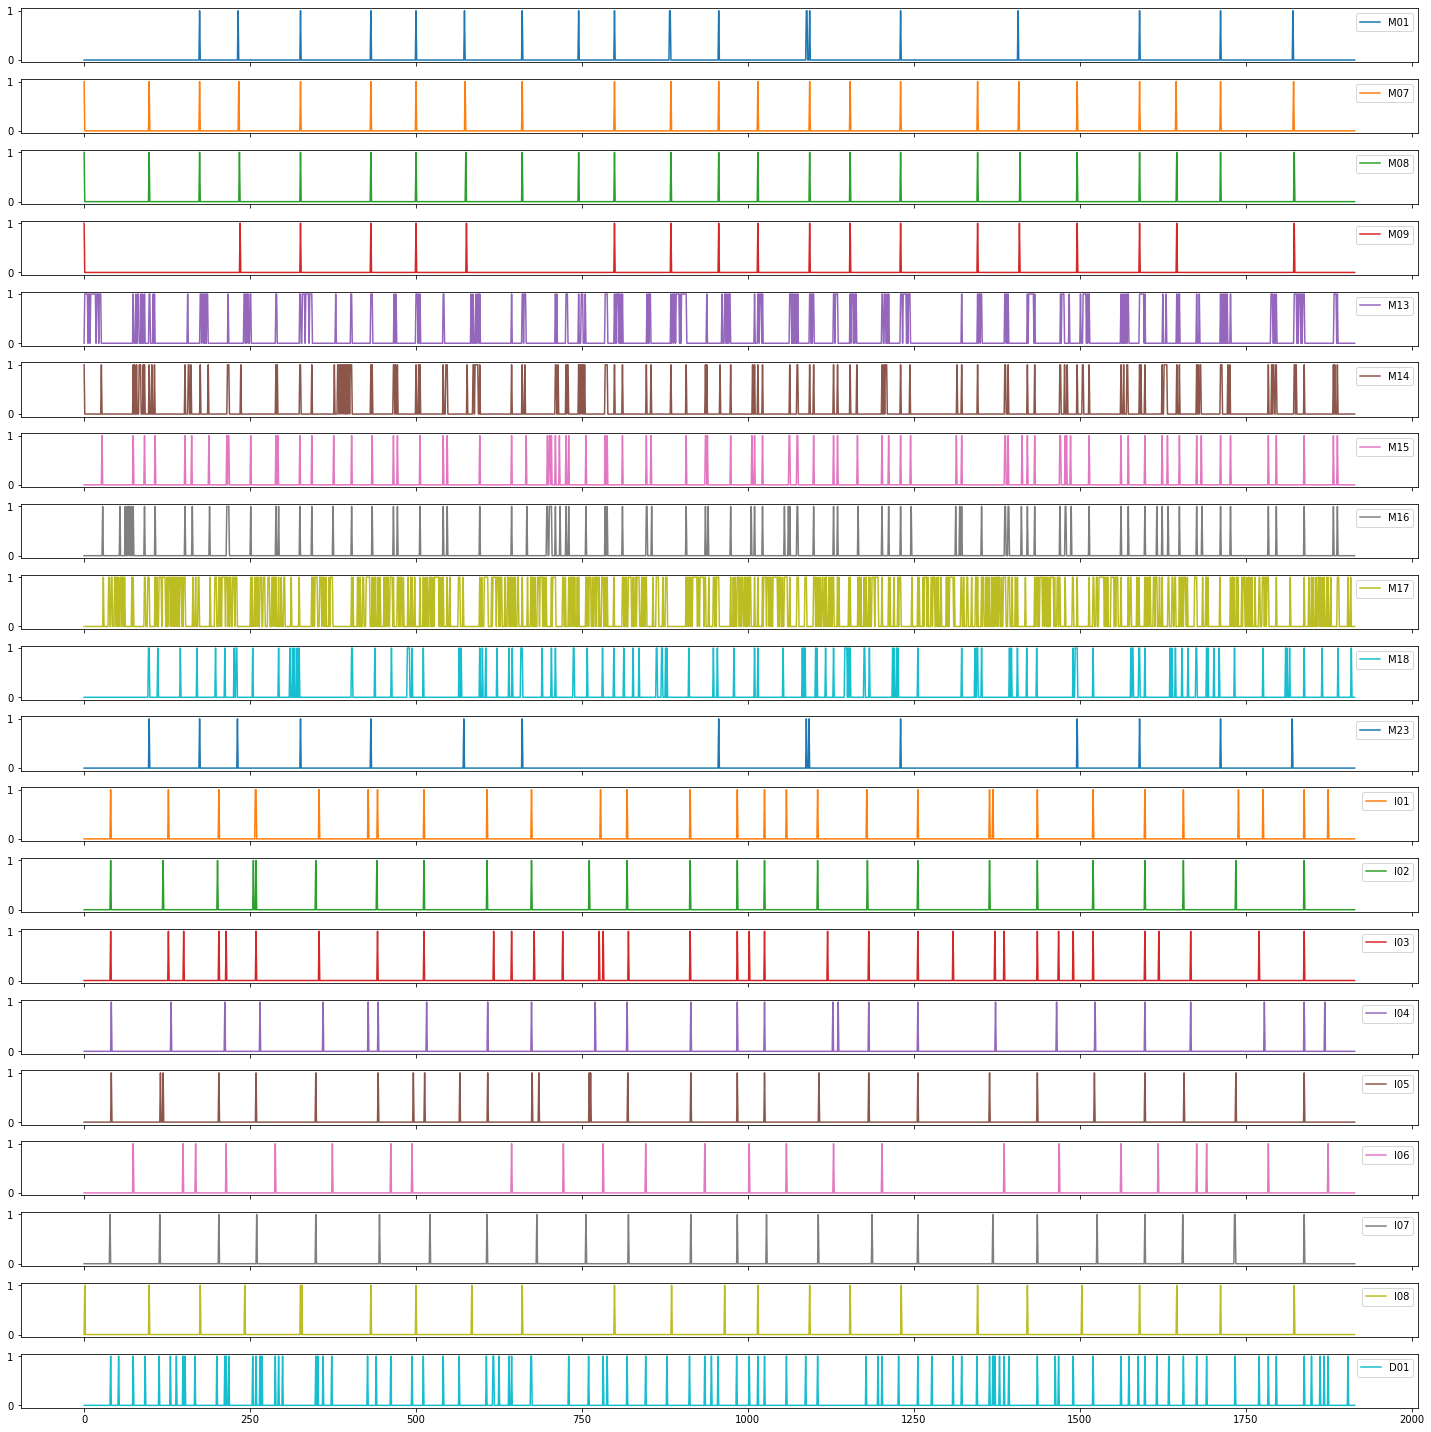

In [18]:
new_data.drop(empty_columns, axis=1, inplace=True)
reversed_mapping = {y: x for x, y in replacement_mapping_dict.items()}
changed_legend = new_data.rename(columns = reversed_mapping)
for column in empty_columns:
    reversed_mapping.pop(column)

changed_legend.plot(subplots=True, figsize=(20,20))
pyplot.tight_layout()
pyplot.savefig("plots/CleanedData.png", format="png", dpi=1200)

Now need to transform the data into a sequence form so that we have predicted labels for each row of data

In [19]:
df = changed_legend.copy()
df.drop(columns=["Date", "Time"], inplace=True)
n_vars = len(df.columns)
cols, names = list(), list()
# input sequence (t-n, ... t-1)
for i in range(1, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
for i in range(0, 1):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# put it all together
agg = concat(cols, axis=1)
agg.columns = names
# drop rows with NaN values
agg.dropna(inplace=True)

Now we need to separate into test and train data

In [20]:
values = agg.values
train_split = int(0.8 * len(values))

train = values[:train_split, :]
test = values[train_split:, :]


train_x, train_y = train[:, :23], train[:, 23:]
test_x, test_y = test[:, :23], test[:, 23:]
train_x = np.asarray(train_x).astype(np.float32)
train_y = np.asarray(train_y).astype(np.float32)
test_y = np.asarray(test_y).astype(np.float32)
test_x = np.asarray(test_x).astype(np.float32)
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))


Now create the network

Epoch 1/100
22/22 - 2s - loss: 0.0875 - val_loss: 0.1041 - 2s/epoch - 90ms/step
Epoch 2/100
22/22 - 0s - loss: 0.0733 - val_loss: 0.0841 - 111ms/epoch - 5ms/step
Epoch 3/100
22/22 - 0s - loss: 0.0680 - val_loss: 0.0753 - 87ms/epoch - 4ms/step
Epoch 4/100
22/22 - 0s - loss: 0.0667 - val_loss: 0.0731 - 90ms/epoch - 4ms/step
Epoch 5/100
22/22 - 0s - loss: 0.0662 - val_loss: 0.0728 - 92ms/epoch - 4ms/step
Epoch 6/100
22/22 - 0s - loss: 0.0659 - val_loss: 0.0725 - 102ms/epoch - 5ms/step
Epoch 7/100
22/22 - 0s - loss: 0.0656 - val_loss: 0.0723 - 94ms/epoch - 4ms/step
Epoch 8/100
22/22 - 0s - loss: 0.0655 - val_loss: 0.0722 - 99ms/epoch - 5ms/step
Epoch 9/100
22/22 - 0s - loss: 0.0653 - val_loss: 0.0720 - 91ms/epoch - 4ms/step
Epoch 10/100
22/22 - 0s - loss: 0.0652 - val_loss: 0.0719 - 92ms/epoch - 4ms/step
Epoch 11/100
22/22 - 0s - loss: 0.0651 - val_loss: 0.0718 - 93ms/epoch - 4ms/step
Epoch 12/100
22/22 - 0s - loss: 0.0650 - val_loss: 0.0717 - 104ms/epoch - 5ms/step
Epoch 13/100
22/22 - 0s

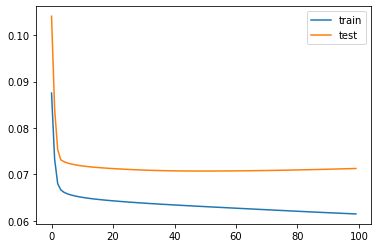

In [21]:
# design network
model = Sequential()
model.add(LSTM(300, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dense(23))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_x, train_y, epochs=100, batch_size=72, validation_data=(test_x, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Now test the model

In [22]:
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], 23))
print(yhat)
# # calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)


12/12 [==============================] - 0s 1ms/step
[[-8.58101808e-03  6.12310879e-03  5.39598428e-03 ...  1.99752557e+00
   1.35564860e-02  1.48052815e-02]
 [ 1.13295326e-02  6.89671375e-03  7.78869539e-03 ...  4.10639316e-01
   2.82882042e-02  1.53763536e-02]
 [ 1.13295326e-02  6.89671375e-03  7.78869539e-03 ...  4.10639316e-01
   2.82882042e-02  1.53763536e-02]
 ...
 [ 9.79100075e-03  2.27059610e-03  1.03830453e-02 ...  4.59835753e-02
   2.03814149e-01  1.10449102e-02]
 [ 1.06814895e-02  1.19441561e-03  9.77547094e-03 ...  1.38510130e-02
   2.27584779e-01  9.55680385e-03]
 [ 6.70332648e-03  6.75665773e-03  1.19012268e-02 ...  1.86834931e-01
   3.65547836e-02  1.00175247e-01]]
Test RMSE: 0.267
